## Análisis del modelo durante distintos periodos (meses) del año 2020

### Pasos

>Carga el modelo entrenado (enero)

>Evalúa varios meses (lista MONTHS)

>Calcula F1 y nº de ejemplos

>Guarda resultados en reports/metrics_monthly_2020.csv

>Genera un gráfico reports/figures/f1_monthly.png

## Bootstrap e imports

In [2]:
# Bootstrap: agrega <repo>/src y <repo>/ al PYTHONPATH para importar los módulos y config
import sys
from pathlib import Path

NB_ROOT = Path.cwd()            # notebooks/
ROOT = NB_ROOT.parent           # repo/
SRC = ROOT / "src"
sys.path.append(str(SRC))       # para importar src/*
sys.path.append(str(ROOT))      # para importar config.py (en la raíz)

# Imports del proyecto
import config
from data.dataset import load_data
from models.predict_model import (
    load_model, make_dataset_from_raw,
    predict_proba, predict_labels_from_proba, evaluate_binary
)

# Libs estándar
import pandas as pd
import matplotlib.pyplot as plt

# Carpetas de salida
REPORTS_DIR = ROOT / "reports"
FIGURES_DIR = REPORTS_DIR / "figures"
REPORTS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

REPORTS_DIR, FIGURES_DIR


(PosixPath('/home/cristian/taxi-tip-classifier/reports'),
 PosixPath('/home/cristian/taxi-tip-classifier/reports/figures'))

## Cargar modelo y define meses

In [3]:
# Carga del modelo entrenado
MODEL_PATH = config.MODEL_PATH          # src/config.py ya lo define como <repo>/models/random_forest.joblib
model = load_model(MODEL_PATH)
MODEL_PATH

PosixPath('/home/cristian/taxi-tip-classifier/models/random_forest.joblib')

In [4]:
# Elige los meses a evaluar (en 2020). Mínimo 3.
MONTHS = [2, 4, 6, 8, 10, 12]   # Feb, Mar, Abr (puedes añadir más)
MONTHS

[2, 4, 6, 8, 10, 12]

## Función de evaluación mensual (automatiza)

In [5]:
def evaluate_multiple_months(model, months, year=2020, target_col="high_tip", threshold=0.5):
    """
    Descarga cada mes desde la CDN, preprocesa de acuerdo al pipeline y calcula métricas.
    Devuelve un DataFrame con columnas: mes, ejemplos, f1.
    """
    rows = []
    for m in months:
        url = f"https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{year}-{m:02d}.parquet"
        print(f"▶ Evaluando {year}-{m:02d} …")
        try:
            df_raw = load_data(url, filetype="parquet")
            X, y, _ = make_dataset_from_raw(df_raw, target_col=target_col)

            proba = predict_proba(model, X)
            y_pred = predict_labels_from_proba(proba, threshold=threshold)
            metrics = evaluate_binary(y_true=y, y_pred=y_pred, y_proba=proba)

            rows.append({
                "mes": m,
                "ejemplos": int(len(y)),
                "f1": float(metrics["f1"])
            })
        except Exception as e:
            print(f"  ⚠️  Error evaluando {year}-{m:02d}: {e}")
            rows.append({"mes": m, "ejemplos": 0, "f1": None})

    return pd.DataFrame(rows).sort_values("mes").reset_index(drop=True)


## Ejecuta evaluación y guarda CSV

In [6]:
df_results = evaluate_multiple_months(model, MONTHS, year=2020)
display(df_results)

# Guardar resultados
out_csv = REPORTS_DIR / "metrics_monthly_2020.csv"
df_results.to_csv(out_csv, index=False)
out_csv


▶ Evaluando 2020-02 …
▶ Evaluando 2020-04 …
▶ Evaluando 2020-06 …
▶ Evaluando 2020-08 …
▶ Evaluando 2020-10 …
▶ Evaluando 2020-12 …


,mes,ejemplos,f1
0,2,6276854,0.734739
1,4,236611,0.610953
2,6,546843,0.647287
3,8,1001832,0.680687
4,10,1673052,0.721151
5,12,1453523,0.716684


PosixPath('/home/cristian/taxi-tip-classifier/reports/metrics_monthly_2020.csv')

## Visualización (línea)

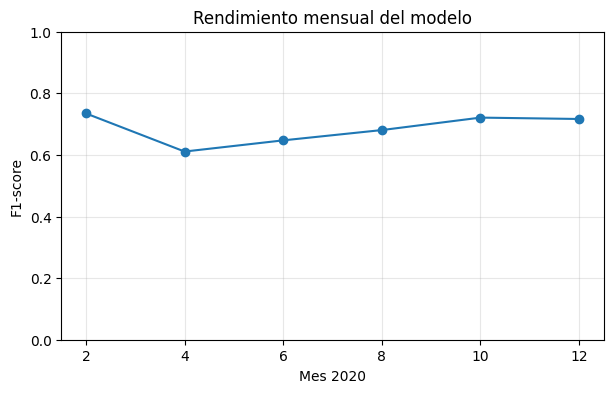

PosixPath('/home/cristian/taxi-tip-classifier/reports/figures/f1_monthly.png')

In [7]:
# Gráfico de F1 por mes
plt.figure(figsize=(7,4))
plt.plot(df_results["mes"], df_results["f1"], marker="o")
plt.xticks(df_results["mes"])
plt.ylim(0, 1)
plt.xlabel("Mes 2020")
plt.ylabel("F1-score")
plt.title("Rendimiento mensual del modelo")
plt.grid(True, alpha=0.3)

fig_path = FIGURES_DIR / "f1_monthly.png"
plt.savefig(fig_path, bbox_inches="tight", dpi=150)
plt.show()

fig_path


## Tabla extendida con media y desviación

In [10]:
resumen = {
    "f1_media": df_results["f1"].dropna().mean(),
    "f1_std": df_results["f1"].dropna().std(),
    "meses_ok": int(df_results["f1"].notna().sum()),
    "total_meses": int(len(df_results))
}
pd.DataFrame([resumen])


,f1_media,f1_std,meses_ok,total_meses
0,0.68525,0.04839,6,6


## Análisis

>El F1 muestra una caida en los meses de febrero a abril, probablemnte incidido por en comienzo de la pandemia de COVID-19. Luego gradualmente comienza a recuperar hasta estabilizarse hacia fin de año en valores que se acercan a valores pre-pandemia. Esto puede significar que si bien al comienzo de la pandemia hubo una fuerte restricción de los viajes, con los meses hubo una tendencia a normalizarse, lo que tiene sentido con el hecho que que al impacto inicial, vino un proceso de adaptación.


>Puede tambibién haber una componente estacional/meterológica en lo que muestra el modelo, lo cual se puede conprobar haciendo un análisis comparativos con años normales, sin pandemia. Queda plantaado.

>Por lo anterior, se plantea enriquecer el análisis con datos temporales/meteorológicas adicionales. Consultar a otras fuentes, como el NOAA. Queda Planteado.

>Para mejorar el modelo, se puede reentrenar en periodos intermedios durante el año.

>Se recomienda usar validación time-series split, Queda planteado

>Se recomienda monitorear el drift y re-entrenar cuando F1 baje de un cierto umbral. Por ejemplo, 0.7, y comparar lso resultados. Queda planteado